In [224]:

from sklearn.model_selection import train_test_split
import nbimporter
import predictive_modeling_f2
from predictive_modeling_f2 import AddNewFeaturesTransformer, CustomOrdinalEncoder, LogTransformSkewed,IsolationForestRemover



In [213]:
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
       correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values()) + [
                Parameter("feature_names_out", Parameter.KEYWORD_ONLY)])

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out

    if not hasattr(CustomOrdinalEncoder, "get_feature_names_out"):
        def custom_ordinal_get_feature_names_out(self, input_features=None):
            """
            Returns output feature names for CustomOrdinalEncoder.
            If self.feature_name is set, returns that. Otherwise, if input_features is provided,
            returns the first feature name (assuming one-to-one mapping), else a default name.
            """
            if hasattr(self, "feature_name") and self.feature_name is not None:
                return np.array([self.feature_name])
            elif input_features is not None and len(input_features) > 0:
                return np.array([input_features[0]])
            else:
                return np.array(["custom_ordinal_encoded_feature"])
        CustomOrdinalEncoder.get_feature_names_out = custom_ordinal_get_feature_names_out

monkey_patch_get_signature_names_out()

In [214]:

df = pd.read_csv("WA_Fn-UseC_-HR-Employee-Attrition.csv")
df.drop(columns=['EmployeeCount', 'StandardHours', 'EmployeeNumber'], inplace=True)
df.drop_duplicates(inplace=True)

# Convert Attrition to binary: 'Yes' → 1, 'No' → 0.
df["Attrition"] = df["Attrition"].map({'Yes': 1, 'No': 0})

X = df.drop("Attrition", axis=1)
y = df["Attrition"]

# Stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Reset indices to ensure alignment
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

In [217]:
import os
import joblib
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    ConfusionMatrixDisplay,
    roc_curve, auc,
    fbeta_score
)

def display_model_details(model_file, X_train, y_train, X_test, y_test):
    """
    Loads a model from the given file, then displays:
      - The pipeline parameters (preprocessing and classifier settings)
      - Classification reports for both the training and test sets
      - Confusion matrices for both the training and test sets using ConfusionMatrixDisplay
      - ROC curves (if available) for both the training and test sets using built-in display functions,
        including a diagonal "no skill" line.
      - Overall accuracy and F2 scores for train and test sets.
    
    Parameters:
    - model_file: str, path to the saved model (e.g., a .joblib file)
    - X_train, y_train: Training data.
    - X_test, y_test: Test data.
    """
    # Load the model
    model = joblib.load(model_file)
    model_name = os.path.splitext(os.path.basename(model_file))[0]
    
    # Display model name and pipeline parameters.
    display(Markdown(f"## Model: {model_name}"))
    params = model.get_params()
    md_params = f"""### Pipeline Parameters for **{model_name}**:
- **outlier:** {params.get('outlier')}
- **add_feats:** {params.get('add_feats')}
- **preprocessor__num__transformer:** {params.get('preprocessor__num__transformer')}
- **preprocessor__num__scaler:** {params.get('preprocessor__num__scaler')}
- **preprocessor__bus__encoder:** {params.get('preprocessor__bus__encoder')}
- **feat_sel:** {params.get('feat_sel')}
- **smote:** {params.get('smote')}
- **classifier:** {params.get('classifier')}
"""
    display(Markdown(md_params))
    
    def display_performance(X, y, dataset_name="Test Set"):
        y_pred = model.predict(X)
        report = classification_report(y, y_pred)
        acc = accuracy_score(y, y_pred)
        # Compute F2 score using beta=2
        f2 = fbeta_score(y, y_pred, beta=2, zero_division=0)
        
        display(Markdown(f"### {dataset_name} Set Classification Report for **{model_name}**"))
        display(Markdown(f"```\n{report}\n```"))
        display(Markdown(f"**{dataset_name} Accuracy for {model_name}:** {acc:.4f}"))
        display(Markdown(f"**{dataset_name} F2 Score for {model_name}:** {f2:.4f}"))
        
        # Plot confusion matrix using ConfusionMatrixDisplay
        disp = ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap=plt.cm.Blues)
        disp.ax_.set_title(f"Confusion Matrix ({dataset_name}) for {model_name}")
        plt.show()
        
        # Plot ROC curve using roc_curve and auc, including the diagonal line.
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X)[:, 1]
            fpr, tpr, thresholds = roc_curve(y, y_prob)
            model_auc = auc(fpr, tpr)
            plt.figure(figsize=(5,4))
            plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (AUC = {model_auc:.2f})")
            plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--", label="No Skill (AUC = 0.5)")
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC Curve ({dataset_name}) for {model_name}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            display(Markdown(f"Model does not support predict_proba; skipping ROC curve for {dataset_name} for {model_name}."))
    
    # Display performance on training data.
    display(Markdown("### Training Set Performance"))
    display_performance(X_train, y_train, dataset_name="Training Set")
    
    # Display performance on test data.
    display(Markdown("### Test Set Performance"))
    display_performance(X_test, y_test, dataset_name="Test Set")


## Model: LogisticRegression_tuned_model

### Pipeline Parameters for **LogisticRegression_tuned_model**:
- **outlier:** IsolationForestRemover()
- **add_feats:** AddNewFeaturesTransformer()
- **preprocessor__num__transformer:** LogTransformSkewed(skewed_cols=['IncomePerYearExp', 'YearsSinceLastPromotion',
                                'YearsAtCompany', 'MonthlyIncome',
                                'TotalWorkingYears', 'NumCompaniesWorked',
                                'DistanceFromHome', 'YearsInCurrentRole',
                                'PercentSalaryHike', 'YearsWithCurrManager'])
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
- **smote:** SMOTE(random_state=42)
- **classifier:** LogisticRegression(C=1, max_iter=500, random_state=42, solver='saga')


### Training Set Performance

### Training Set Set Classification Report for **LogisticRegression_tuned_model**

```
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       986
           1       0.42      0.79      0.55       190

    accuracy                           0.79      1176
   macro avg       0.69      0.79      0.71      1176
weighted avg       0.87      0.79      0.81      1176

```

**Training Set Accuracy for LogisticRegression_tuned_model:** 0.7891

**Training Set F2 Score for LogisticRegression_tuned_model:** 0.6741

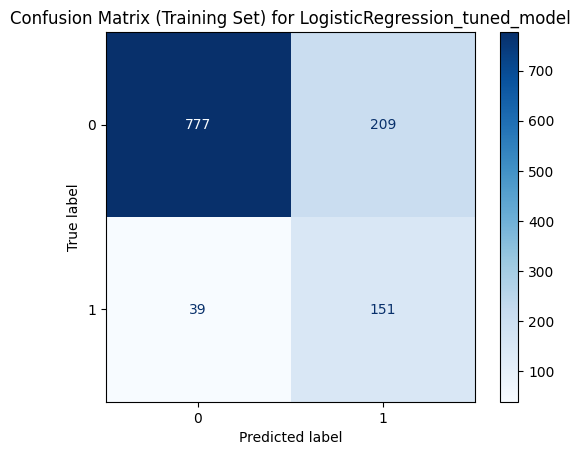

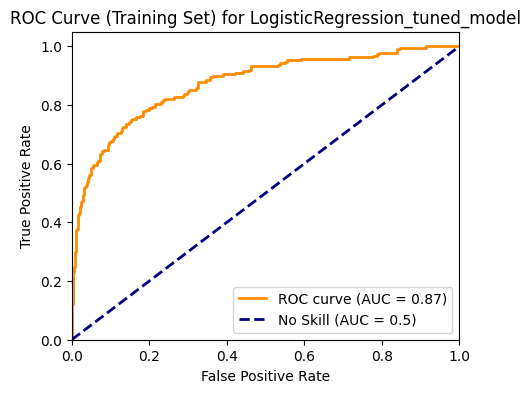

### Test Set Performance

### Test Set Set Classification Report for **LogisticRegression_tuned_model**

```
              precision    recall  f1-score   support

           0       0.93      0.81      0.86       247
           1       0.39      0.66      0.49        47

    accuracy                           0.78       294
   macro avg       0.66      0.73      0.68       294
weighted avg       0.84      0.78      0.80       294

```

**Test Set Accuracy for LogisticRegression_tuned_model:** 0.7823

**Test Set F2 Score for LogisticRegression_tuned_model:** 0.5805

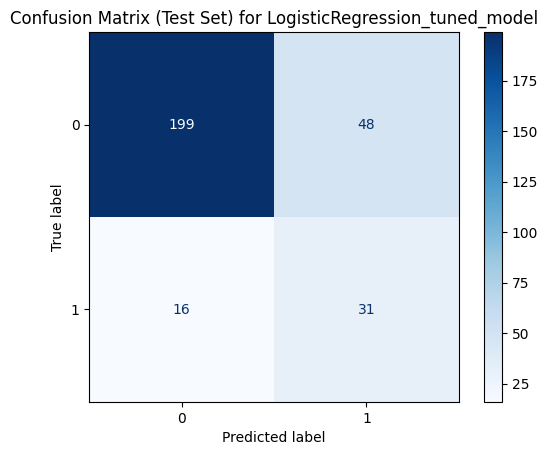

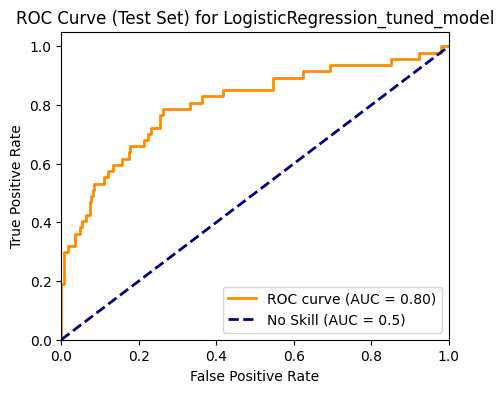

In [218]:
model_file = "models/LogisticRegression_tuned_model.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: DecisionTree_tuned_model

### Pipeline Parameters for **DecisionTree_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>)
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** SelectFromModel(estimator=RandomForestClassifier(random_state=42),
                threshold='median')
- **classifier:** DecisionTreeClassifier(min_samples_leaf=2, min_samples_split=10,
                       random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **DecisionTree_tuned_model**

```
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       986
           1       0.88      0.72      0.79       190

    accuracy                           0.94      1176
   macro avg       0.91      0.85      0.88      1176
weighted avg       0.94      0.94      0.94      1176

```

**Training Set Accuracy for DecisionTree_tuned_model:** 0.9379

**Training Set F2 Score for DecisionTree_tuned_model:** 0.7432

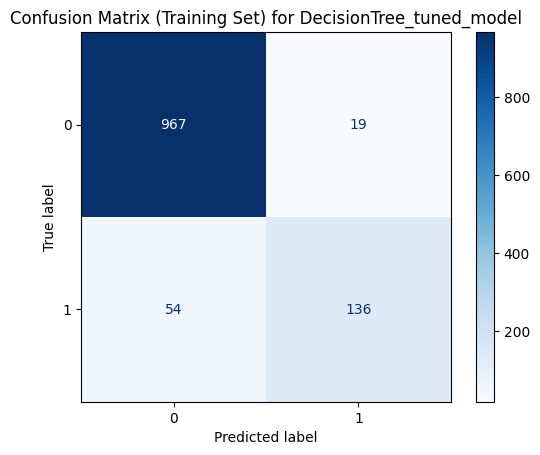

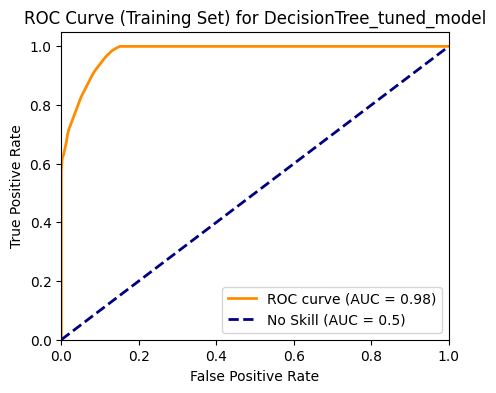

### Test Set Performance

### Test Set Set Classification Report for **DecisionTree_tuned_model**

```
              precision    recall  f1-score   support

           0       0.87      0.87      0.87       247
           1       0.34      0.34      0.34        47

    accuracy                           0.79       294
   macro avg       0.61      0.61      0.61       294
weighted avg       0.79      0.79      0.79       294

```

**Test Set Accuracy for DecisionTree_tuned_model:** 0.7891

**Test Set F2 Score for DecisionTree_tuned_model:** 0.3404

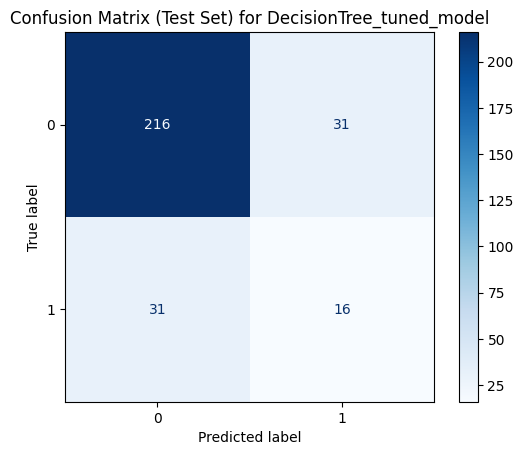

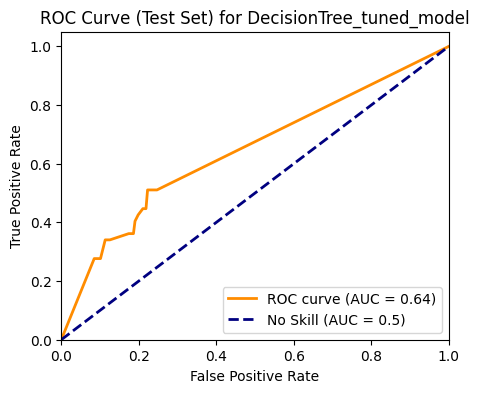

In [ ]:
model_file = "models/DecisionTree_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: RandomForest_tuned_model

### Pipeline Parameters for **RandomForest_tuned_model**:
- **preprocessor__num__log:** passthrough
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** RFE(estimator=LogisticRegression(max_iter=500, random_state=42),
    n_features_to_select=10)
- **classifier:** RandomForestClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=5,
                       random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **RandomForest_tuned_model**

```
              precision    recall  f1-score   support

           0       0.91      0.89      0.90       986
           1       0.50      0.56      0.53       190

    accuracy                           0.84      1176
   macro avg       0.71      0.73      0.72      1176
weighted avg       0.85      0.84      0.84      1176

```

**Training Set Accuracy for RandomForest_tuned_model:** 0.8401

**Training Set F2 Score for RandomForest_tuned_model:** 0.5504

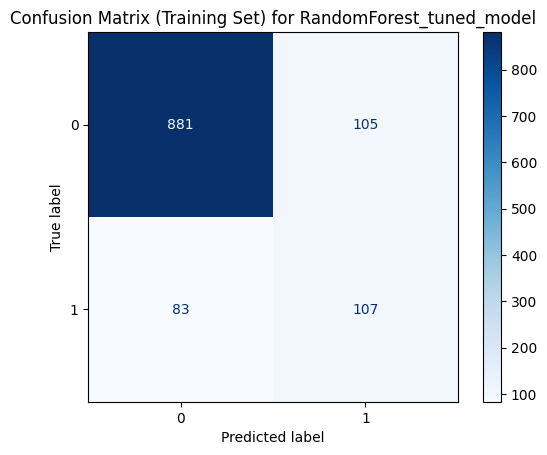

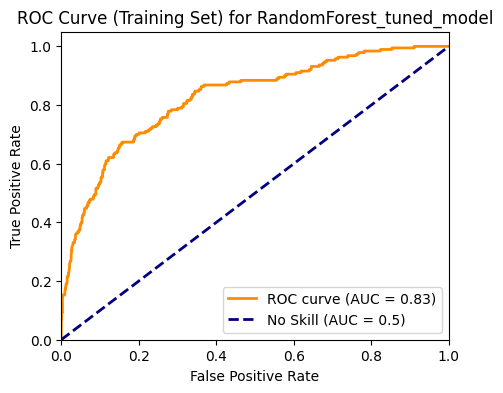

### Test Set Performance

### Test Set Set Classification Report for **RandomForest_tuned_model**

```
              precision    recall  f1-score   support

           0       0.90      0.82      0.86       247
           1       0.35      0.51      0.42        47

    accuracy                           0.77       294
   macro avg       0.63      0.67      0.64       294
weighted avg       0.81      0.77      0.79       294

```

**Test Set Accuracy for RandomForest_tuned_model:** 0.7721

**Test Set F2 Score for RandomForest_tuned_model:** 0.4688

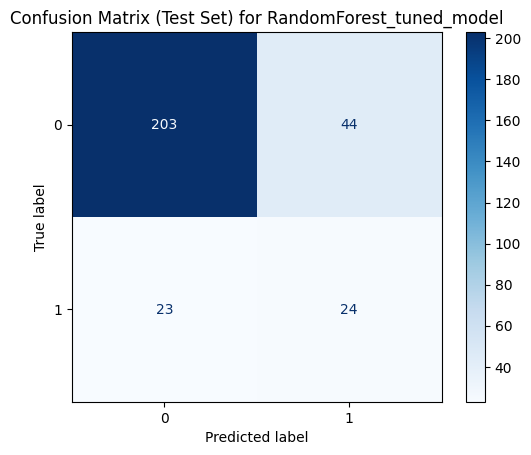

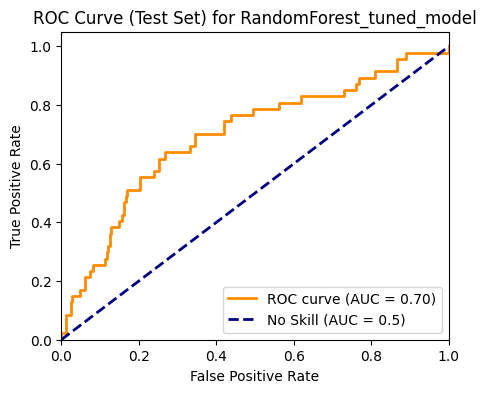

In [ ]:
model_file = "models/RandomForest_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: GradientBoosting_tuned_model

### Pipeline Parameters for **GradientBoosting_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>)
- **preprocessor__num__scaler:** MinMaxScaler()
- **preprocessor__bus__encoder:** OneHotEncoder(drop='first')
- **feat_sel:** SelectFromModel(estimator=LogisticRegression(penalty='l1', random_state=42,
                                             solver='liblinear'))
- **classifier:** GradientBoostingClassifier(learning_rate=0.01, max_features='log2',
                           n_estimators=200, random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **GradientBoosting_tuned_model**

```
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       986
           1       0.61      0.61      0.61       190

    accuracy                           0.88      1176
   macro avg       0.77      0.77      0.77      1176
weighted avg       0.87      0.88      0.87      1176

```

**Training Set Accuracy for GradientBoosting_tuned_model:** 0.8750

**Training Set F2 Score for GradientBoosting_tuned_model:** 0.6112

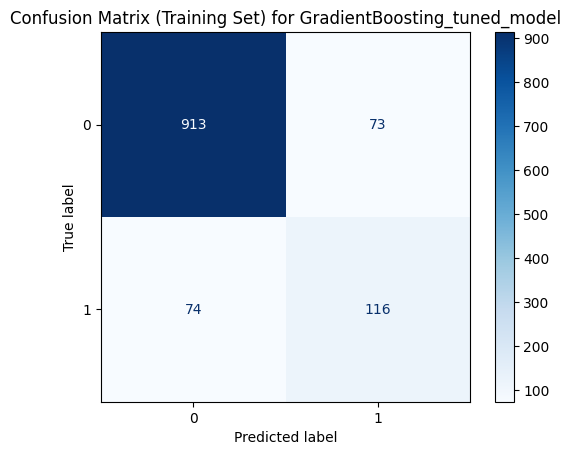

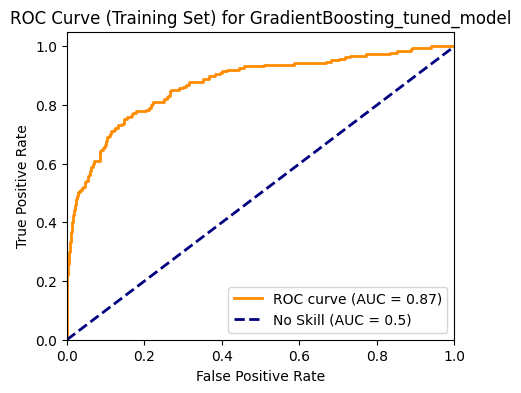

### Test Set Performance

### Test Set Set Classification Report for **GradientBoosting_tuned_model**

```
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       247
           1       0.37      0.40      0.39        47

    accuracy                           0.80       294
   macro avg       0.63      0.64      0.63       294
weighted avg       0.80      0.80      0.80       294

```

**Test Set Accuracy for GradientBoosting_tuned_model:** 0.7959

**Test Set F2 Score for GradientBoosting_tuned_model:** 0.3975

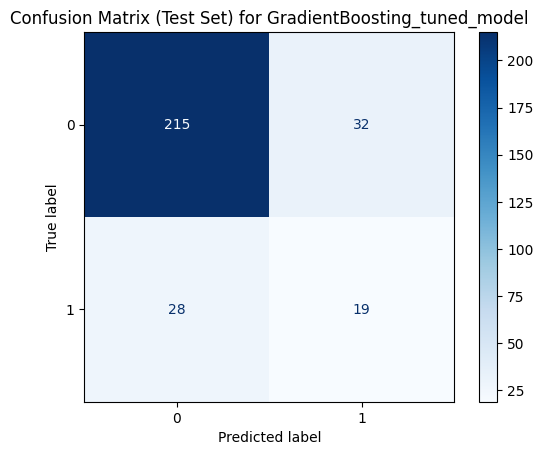

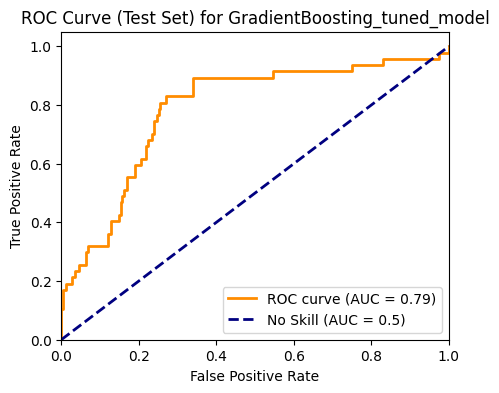

In [ ]:
model_file = "models/GradientBoosting_tuned_model.joblib" 
display_model_details(model_file, X_train, y_train,X_test, y_test)

## Model: MLP_tuned_model

### Pipeline Parameters for **MLP_tuned_model**:
- **preprocessor__num__log:** FunctionTransformer(feature_names_out='one-to-one', func=<ufunc 'log1p'>)
- **preprocessor__num__scaler:** StandardScaler()
- **preprocessor__bus__encoder:** CustomOrdinalEncoder(mapping={'Non-Travel': 0, 'Travel_Frequently': 2,
                              'Travel_Rarely': 1})
- **feat_sel:** passthrough
- **classifier:** MLPClassifier(activation='tanh', hidden_layer_sizes=(50,), max_iter=500,
              random_state=42)


### Training Set Performance

### Training Set Set Classification Report for **MLP_tuned_model**

```
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       190

    accuracy                           1.00      1176
   macro avg       1.00      1.00      1.00      1176
weighted avg       1.00      1.00      1.00      1176

```

**Training Set Accuracy for MLP_tuned_model:** 1.0000

**Training Set F2 Score for MLP_tuned_model:** 1.0000

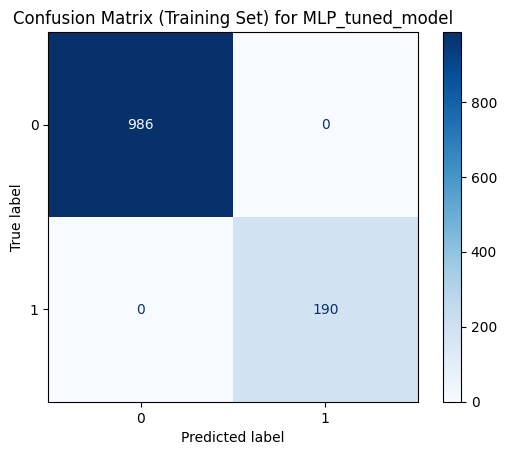

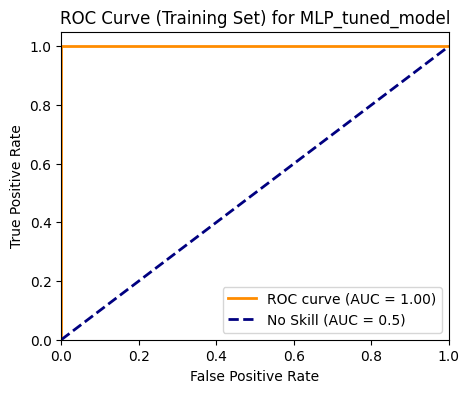

### Test Set Performance

### Test Set Set Classification Report for **MLP_tuned_model**

```
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.53      0.49      0.51        47

    accuracy                           0.85       294
   macro avg       0.72      0.70      0.71       294
weighted avg       0.85      0.85      0.85       294

```

**Test Set Accuracy for MLP_tuned_model:** 0.8503

**Test Set F2 Score for MLP_tuned_model:** 0.4978

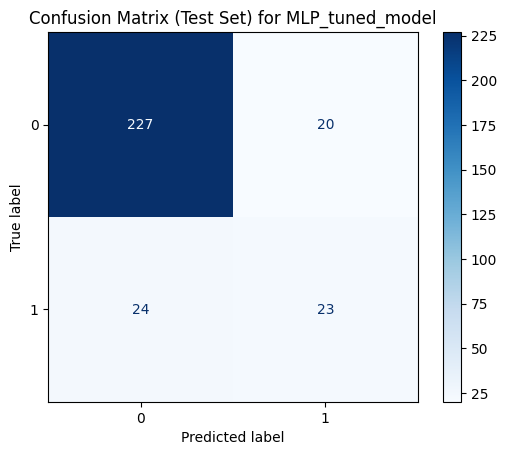

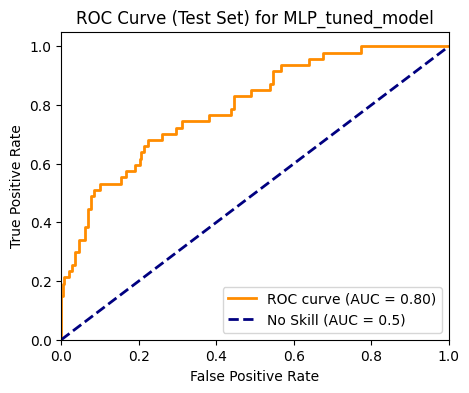

In [ ]:
model_file = "models/MLP_tuned_model.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: stacking_logistic_regression

### Pipeline Parameters for **stacking_logistic_regression**:
- **preprocessor__num__log:** None
- **preprocessor__num__scaler:** None
- **preprocessor__bus__encoder:** None
- **feat_sel:** None
- **classifier:** None


### Training Set Performance

### Training Set Set Classification Report for **stacking_logistic_regression**

```
              precision    recall  f1-score   support

           0       0.95      1.00      0.97       986
           1       1.00      0.71      0.83       190

    accuracy                           0.95      1176
   macro avg       0.97      0.86      0.90      1176
weighted avg       0.96      0.95      0.95      1176

```

**Training Set Accuracy for stacking_logistic_regression:** 0.9532

**Training Set F2 Score for stacking_logistic_regression:** 0.7542

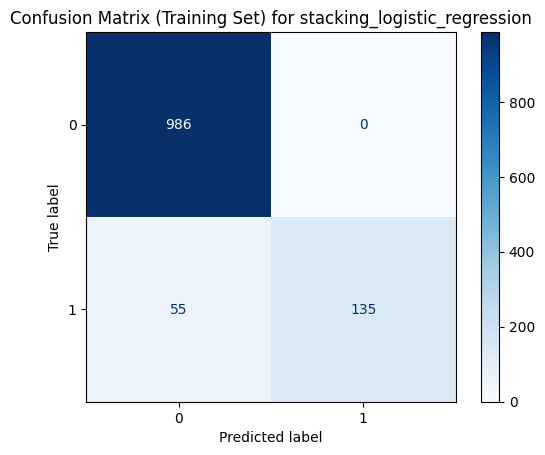

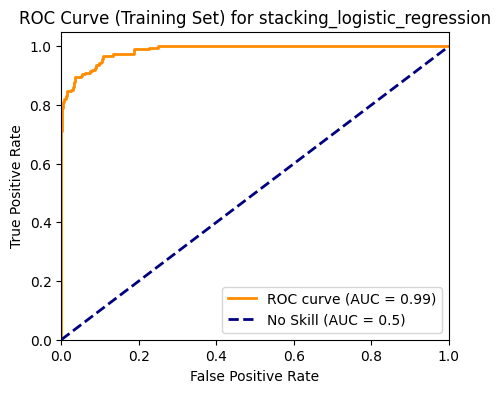

### Test Set Performance

### Test Set Set Classification Report for **stacking_logistic_regression**

```
              precision    recall  f1-score   support

           0       0.89      0.96      0.92       247
           1       0.64      0.38      0.48        47

    accuracy                           0.87       294
   macro avg       0.77      0.67      0.70       294
weighted avg       0.85      0.87      0.85       294

```

**Test Set Accuracy for stacking_logistic_regression:** 0.8673

**Test Set F2 Score for stacking_logistic_regression:** 0.4167

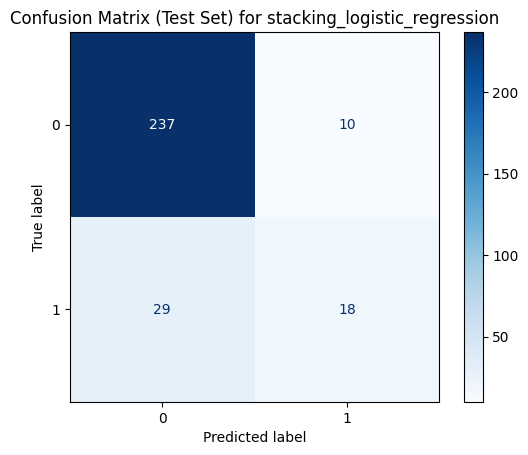

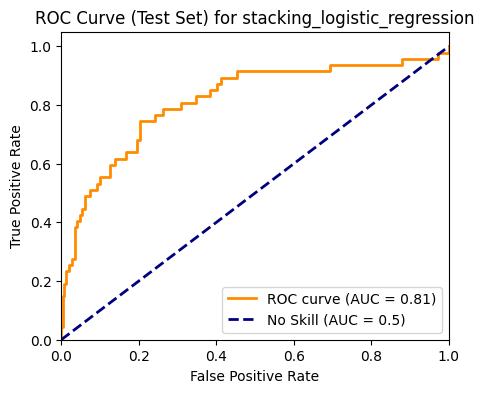

In [ ]:
model_file = "models/stacking_logistic_regression.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

## Model: stacking_decision_tree

### Pipeline Parameters for **stacking_decision_tree**:
- **preprocessor__num__log:** None
- **preprocessor__num__scaler:** None
- **preprocessor__bus__encoder:** None
- **feat_sel:** None
- **classifier:** None


### Training Set Performance

### Training Set Set Classification Report for **stacking_decision_tree**

```
              precision    recall  f1-score   support

           0       0.91      0.99      0.95       986
           1       0.92      0.49      0.64       190

    accuracy                           0.91      1176
   macro avg       0.92      0.74      0.80      1176
weighted avg       0.91      0.91      0.90      1176

```

**Training Set Accuracy for stacking_decision_tree:** 0.9116

**Training Set F2 Score for stacking_decision_tree:** 0.5452

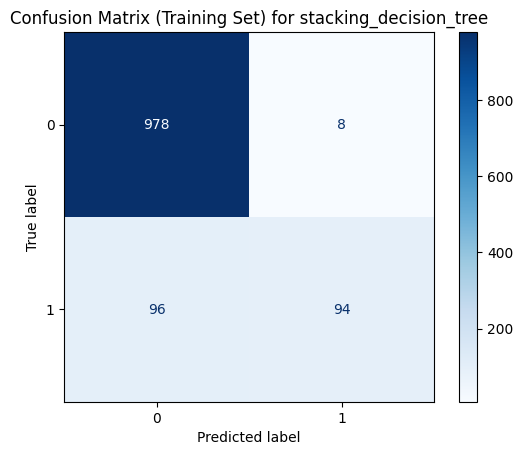

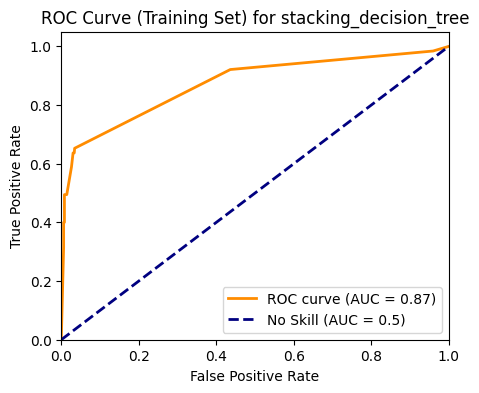

### Test Set Performance

### Test Set Set Classification Report for **stacking_decision_tree**

```
              precision    recall  f1-score   support

           0       0.87      0.98      0.92       247
           1       0.67      0.21      0.32        47

    accuracy                           0.86       294
   macro avg       0.77      0.60      0.62       294
weighted avg       0.84      0.86      0.82       294

```

**Test Set Accuracy for stacking_decision_tree:** 0.8571

**Test Set F2 Score for stacking_decision_tree:** 0.2463

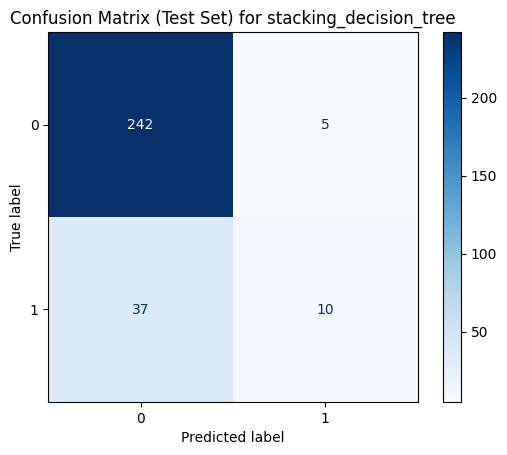

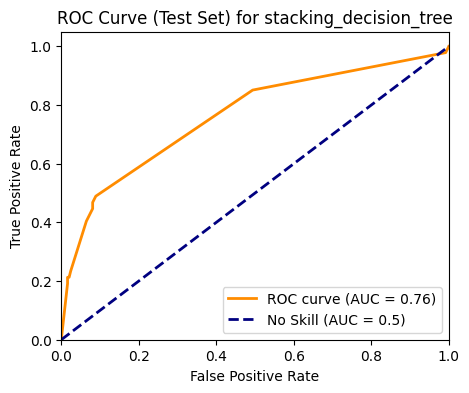

In [ ]:
model_file = "models/stacking_decision_tree.joblib" 
display_model_details(model_file,X_train, y_train, X_test, y_test)

# Interpreting the logistic regression model

Intercept: [2.331779]
Coefficients: [[-1.11333838 -0.96112764  1.15646432 -0.09339646  1.58428711 -0.65494046
  -2.65888723 -0.6202552  -1.15283792  2.41054919 -1.82848012  0.02103986
  -0.41445371 -0.40628804  0.20999435 -0.38155938  0.12500184 -0.25022766
  -0.18426313 -0.34392358  1.02683235 -0.22873401 -0.11066602 -1.15987704
   0.12351669  0.30698374  0.91284865  1.4373646  -0.17590452 -2.38522082
   0.71365378  1.73707692  0.34644534  1.10122531  1.83991646]]
['num__Age' 'num__DailyRate' 'num__DistanceFromHome' 'num__HourlyRate'
 'num__MonthlyIncome' 'num__MonthlyRate' 'num__NumCompaniesWorked'
 'num__PercentSalaryHike' 'num__TotalWorkingYears'
 'num__TrainingTimesLastYear' 'num__YearsAtCompany'
 'num__YearsInCurrentRole' 'num__YearsSinceLastPromotion'
 'num__YearsWithCurrManager' 'ord__Education'
 'ord__EnvironmentSatisfaction' 'ord__JobInvolvement' 'ord__JobLevel'
 'ord__JobSatisfaction' 'ord__PerformanceRating'
 'ord__RelationshipSatisfaction' 'ord__StockOptionLevel'
 'ord__Wo

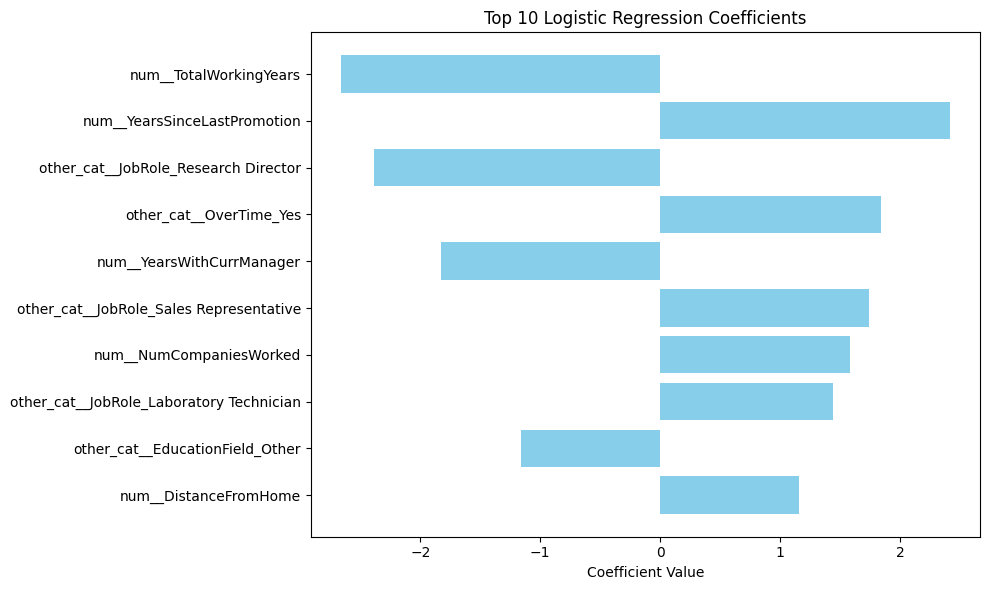

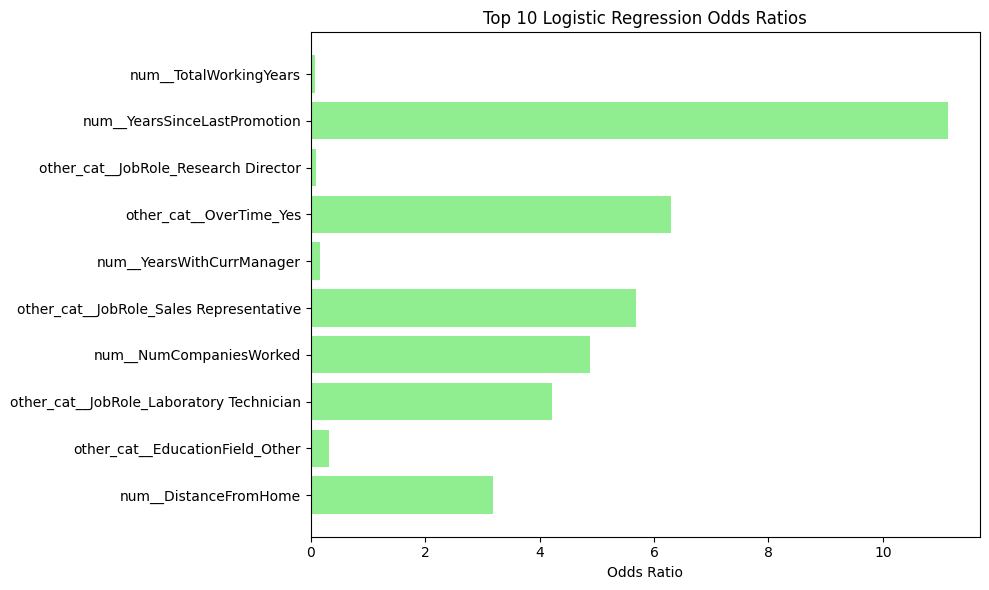

In [219]:
import joblib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the saved model from disk (adjust the path as needed)
model_file = "models/LogisticRegression_tuned_model.joblib"
lr_pipeline = joblib.load(model_file)

# Extract the classifier from the pipeline.
classifier = lr_pipeline.named_steps['classifier']

# Print the intercept and coefficients.
print("Intercept:", classifier.intercept_)
print("Coefficients:", classifier.coef_)

# Extract the preprocessor and feature selector from the pipeline.
preprocessor = lr_pipeline.named_steps['preprocessor']
feature_selector = lr_pipeline.named_steps['feat_sel']  # Replace 'feat_sel' with your actual feature selection step name if different.
print(preprocessor.get_feature_names_out())

# Get the feature names after preprocessing.
try:
    # Get feature names from the preprocessor.
    preprocessed_feature_names = preprocessor.get_feature_names_out()
except AttributeError:
    # If not available, create dummy feature names based on the number of features.
    # Note: Replace X_train with your actual training data if available.
    n_features = preprocessor.transform(X_train).shape[1]
    preprocessed_feature_names = [f"feature_{i}" for i in range(n_features)]

# Get the selected feature names from the feature selector.
selected_feature_indices = feature_selector.get_support(indices=True)  # Get indices of selected features.
selected_feature_names = preprocessed_feature_names[selected_feature_indices]  # Filter feature names.

# Calculate odds ratios from the coefficients.
odds_ratios = np.exp(classifier.coef_)

# Create a DataFrame to display coefficients and odds ratios.
coef_df = pd.DataFrame({
    "Feature": selected_feature_names,
    "Coefficient": classifier.coef_.ravel(),
    "Odds Ratio": odds_ratios.ravel()
})

# Sort the DataFrame by the absolute value of the coefficients in descending order and select the top 10.
top_coef_df = coef_df.reindex(coef_df['Coefficient'].abs().sort_values(ascending=False).index).head(10)

print(top_coef_df)

# Plot a horizontal bar chart for the top 10 coefficients.
plt.figure(figsize=(10, 6))
plt.barh(top_coef_df["Feature"], top_coef_df["Coefficient"], color="skyblue")
plt.xlabel("Coefficient Value")
plt.title("Top 10 Logistic Regression Coefficients")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest coefficient on top
plt.tight_layout()
plt.show()



# Plot a horizontal bar chart for the top 10 odds ratios.
plt.figure(figsize=(10, 6))
plt.barh(top_coef_df["Feature"], top_coef_df["Odds Ratio"], color="lightgreen")
plt.xlabel("Odds Ratio")
plt.title("Top 10 Logistic Regression Odds Ratios")
plt.gca().invert_yaxis()  # Invert y-axis to have the highest odds ratio on top
plt.tight_layout()
plt.show()


In [230]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)):

    from IPython.display import display, Markdown
    """
    Plots the learning curve for a given estimator.
    
    Parameters:
    - estimator: The model or pipeline to evaluate.
    - X: Feature data.
    - y: Target data.
    - cv: Number of cross-validation folds (or a CV splitter).
    - scoring: Scoring metric to use.
    - train_sizes: Array of training set proportions to use.
    """
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes, n_jobs=-1
    )
    
    # Calculate means and standard deviations for plotting
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std  = np.std(train_scores, axis=1)
    test_scores_mean  = np.mean(test_scores, axis=1)
    test_scores_std   = np.std(test_scores, axis=1)
    
    plt.figure(figsize=(8, 6))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="CV score")
    plt.title("Learning Curve")
    plt.xlabel("Number of Training Examples")
    plt.ylabel("F2 Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()




In [ ]:

# Load the saved model from disk (adjust the path as needed)
model_file = "models/GradientBoosting_tuned_model.joblib"
lr_pipeline = joblib.load(model_file)


plot_learning_curve(lr_pipeline, X_train, y_train, cv=5, scoring=f2_scorer)


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.